In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import PowerNorm

In [47]:
# Parameters
n_idvl = 32
n_char_loc = 8

In [48]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
# Load data
df = pd.read_csv('../data/newport.csv', low_memory=False)
tr = pd.read_csv('../data/newport_melted.csv')

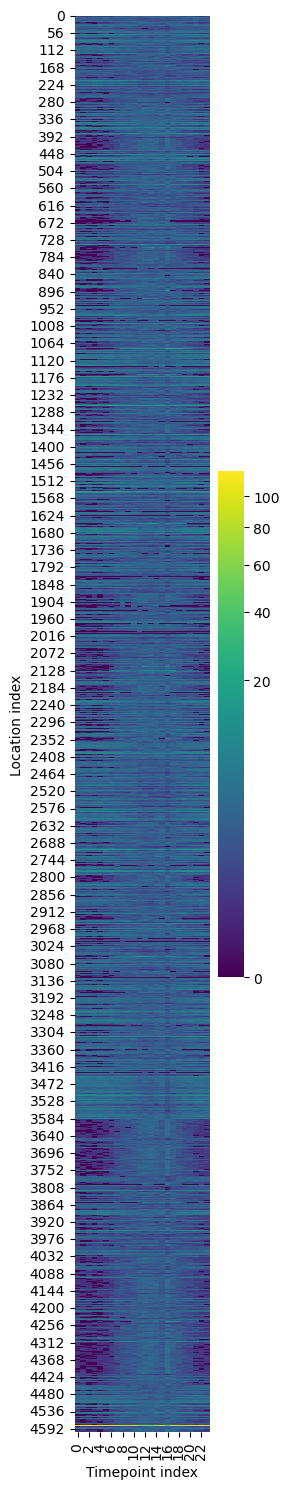

In [50]:
# Create city_target tensor

# Unique places and timepoints
timepoints = np.sort(tr['t'].unique())           
loc_ids = sorted(tr['loc_id'].unique())          
n_timepoint = len(timepoints)
n_location = len(loc_ids)

# Index maps
loc_id_to_idx = {lid: i for i, lid in enumerate(loc_ids)}
t_to_idx = {t: i for i, t in enumerate(timepoints)}

# Target tensor
city_target = torch.full((n_location, n_timepoint), float('nan'))

for _, row in tr.iterrows():
  l_idx = loc_id_to_idx[row['loc_id']]
  t_idx = t_to_idx[row['t']]
  city_target[l_idx, t_idx] = row['visits']

# Verify
verify_city_target = True
if verify_city_target:
  plt.figure(figsize=(3, 15))
  sns.heatmap(city_target.cpu().numpy(), cmap='viridis', cbar=True, norm = PowerNorm(gamma=0.3))

  plt.xlabel("Timepoint index")
  plt.ylabel("Location index")
  plt.tight_layout()
  plt.show()

In [51]:
# Randomly select n_char_loc locations for each individual
# Identify residential and nonresidential loc_ids
# Filter residential locations with their square footage
res_df = df[df['prim_occ'] == 'Single Family Dwelling']
res_locs = res_df['loc_id'].values
res_weights = res_df['sqfeet'].astype(float).values
res_weights /= res_weights.sum()  # Normalize to sum to 1

nonres_locs = df[df['prim_occ'] != 'Single Family Dwelling']['loc_id'].unique()

idvl_loc_ids = []
for _ in range(n_idvl):
    # Weighted sample of primary residential location
    res_loc = np.random.choice(res_locs, p=res_weights)

    # Determine count of nonresidential vs residential among the other locations
    n_other = n_char_loc - 1
    n_nonres = int(np.round(n_other * 0.9))
    n_res = n_other - n_nonres

    # Sample additional locations (excluding the already selected one)
    other_nonres = np.random.choice(
        nonres_locs, size=n_nonres, replace=False
    )
    other_res = np.random.choice(
        res_locs[res_locs != res_loc], size=n_res, replace=False
    )

    locs = [res_loc] + list(other_nonres) + list(other_res)
    idvl_loc_ids.append(locs)  # Residential first


# Verify
#for i, locs in enumerate(idvl_loc_ids):
#    print(f"Individual {i}: {locs}")
    
#df[df['loc_id'] == idvl_loc_ids[0][0]]

In [52]:
# Create AMPNet model
class AMPNet(nn.Module):
    def __init__(self, n_agents, hidden_size, n_char_loc):
        super().__init__()
        self.n_agents = n_agents
        self.hidden_size = hidden_size
        self.n_char_loc = n_char_loc

        self.W1 = nn.Parameter(torch.randn(n_agents, hidden_size, 1) * 0.1)
        self.b1 = nn.Parameter(torch.zeros(n_agents, 1, hidden_size))

        self.W2 = nn.Parameter(torch.randn(n_agents, hidden_size, hidden_size) * 0.1)
        self.b2 = nn.Parameter(torch.zeros(n_agents, 1, hidden_size))

        self.W3 = nn.Parameter(torch.randn(n_agents, n_char_loc, hidden_size) * 0.1)
        self.b3 = nn.Parameter(torch.zeros(n_agents, 1, n_char_loc))

    def forward(self, t):
        # t: (n_agents, T, 1)
        h1 = torch.matmul(t, self.W1.transpose(1, 2)) + self.b1  # (n_agents, T, hidden_size)
        h1 = F.relu(h1)

        h2 = torch.matmul(h1, self.W2.transpose(1, 2)) + self.b2  # (n_agents, T, hidden_size)
        h2 = F.relu(h2)

        out = torch.matmul(h2, self.W3.transpose(1, 2)) + self.b3  # (n_agents, T, n_char_loc)
        out = F.softmax(out, dim=-1)
        return out


In [53]:
# Multinomial negative log likelihood
def multinomial_nll(p, x):
    eps = 1e-8 
    log_p = torch.log(p + eps)
    nll = -(x * log_p).sum()
    return nll

In [54]:
# Prepare input and target batches

## Batched time inputs
t_matrix = torch.tensor(timepoints, dtype=torch.float32).unsqueeze(0).repeat(n_idvl, 1)  # (n_idvl, T)
t_vals = t_matrix.unsqueeze(2).to(device)  # (n_idvl, T, 1)

## Batched targets
targets = []
for i in range(n_idvl):
    idx_i = [loc_id_to_idx[loc] for loc in idvl_loc_ids[i]]
    targets.append(city_target[idx_i, :].T)
targets = torch.stack(targets, dim=0).to(device)  # (n_idvl, T, n_char_loc)


In [55]:
# Optionally check 

do_check = False
if do_check:
  i = 0  # individual to check
  j = 2  # location to check

  loc_id = idvl_loc_ids[i][j]
  loc_idx = loc_id_to_idx[loc_id]

  ## Check from the batched targets tensor
  print("From targets tensor (batched):")
  print(targets[i, :, j].cpu().numpy())  

  ## Check from the city_target tensor (master, full city)
  print("From city_target tensor (full city):")
  print(city_target[loc_idx, :].cpu().numpy()) 

In [56]:
# Initialize AMPNet and optimizer
hidden_size = 64  
batched_model = AMPNet(n_idvl, hidden_size, n_char_loc).to(device)
optimizer = torch.optim.Adam(batched_model.parameters(), lr=1e-2)

In [58]:
# Training
n_epoch = 1000
for epoch in range(n_epoch):
    batched_model.train()
    optimizer.zero_grad()

    preds = batched_model(t_vals)  

    eps = 1e-8
    log_preds = torch.log(preds + eps)
    loss = -(targets * log_preds).sum() / n_idvl  

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")


Epoch 0: loss = 573.0592
Epoch 100: loss = 562.0125
Epoch 200: loss = 560.8185
Epoch 300: loss = 559.9014
Epoch 400: loss = 559.0977
Epoch 500: loss = 558.3701
Epoch 600: loss = 557.7316
Epoch 700: loss = 557.1401
Epoch 800: loss = 556.6269
Epoch 900: loss = 556.1428


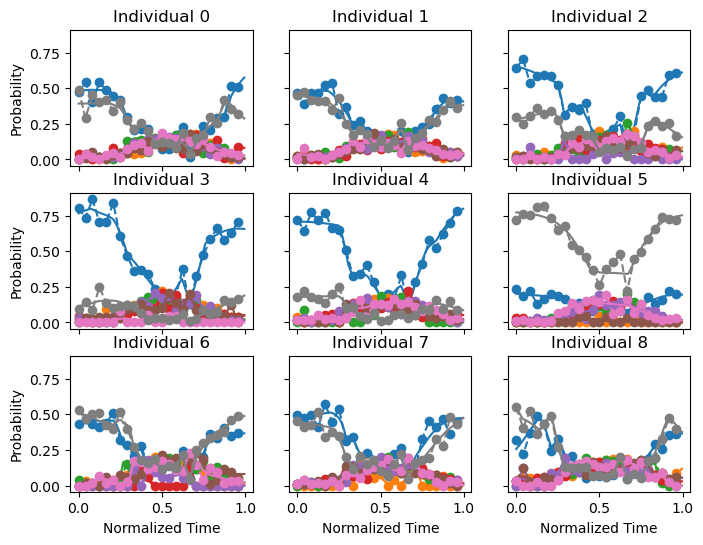

In [60]:
n_show = 9  # number of individuals to show
fine_times = np.linspace(0, 1, 240, endpoint=False)
T_fine = len(fine_times)

# Prepare input: (n_agents, T_fine, 1)
t_fine = torch.tensor(fine_times, dtype=torch.float32).unsqueeze(0).unsqueeze(2).repeat(n_idvl, 1, 1).to(device)  # (n_idvl, T_fine, 1)

# Predict
batched_model.eval()
with torch.no_grad():
    pred_fine = batched_model(t_fine)  # (n_idvl, T_fine, n_char_loc)
    pred_fine_np = pred_fine.cpu().numpy()

fig, axes = plt.subplots(3, 3, figsize=(8, 6), sharex=True, sharey=True)
colors = plt.colormaps['tab10']

for idvl in range(n_show):
    ax = axes[idvl // 3, idvl % 3]

    target_np = targets[idvl].cpu().numpy()  
    target_probs = target_np / target_np.sum(axis=1, keepdims=True)
    for j in range(n_char_loc):
        color = colors(j % colors.N)
        ax.plot(fine_times, pred_fine_np[idvl, :, j], color=color, linestyle='-', label=f'Loc {j} Pred' if idvl == 0 else None)
        ax.plot(timepoints, target_probs[:, j], color=color, linestyle='--', marker='o', label=f'Loc {j} Target' if idvl == 0 else None)
    ax.set_title(f'Individual {idvl}')
    if idvl % 3 == 0:
        ax.set_ylabel('Probability')
    if idvl // 3 == 2:
        ax.set_xlabel('Normalized Time')

plt.show()
